In [1]:
import mlfinlab
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline


In [2]:
help(mlfinlab)
# load data
data = pd.read_csv('./ES.csv', nrows=100000)
data.head()

Help on package mlfinlab:

NAME
    mlfinlab - Package based on the text book: Advances in Financial Machine Learning, by Marcos Lopez de Prado

PACKAGE CONTENTS
    data_structures (package)
    features (package)
    filters (package)
    labeling (package)
    multi_product (package)
    sample_weights (package)
    sampling (package)
    tests (package)
    util (package)

SUBMODULES
    fracdiff
    microstructural

FILE
    /Users/maksimivanov/research/Chapter19/mlfinlab/__init__.py




,Symbol,Date and Time,Price,Volume,Market Flag,Sales Condition,Exclude Record Flag,Unfiltered Price
0,ESH17,2017/01/02 17:00:00.077,2240.75,1360,E,0,NaN,2240.75
1,ESH17,2017/01/02 17:00:00.140,2241.00,1,E,0,NaN,2241.00
2,ESH17,2017/01/02 17:00:00.140,2241.00,5,E,0,NaN,2241.00
3,ESH17,2017/01/02 17:00:00.140,2241.00,1,E,0,NaN,2241.00
4,ESH17,2017/01/02 17:00:00.140,2240.75,15,E,0,NaN,2240.75


# Microstructure features

Market microstructure features aim to tease out useful information from the trading behavior of market participants on exchanges. These features have become more popular with the increased amount and granularity of data provided by exchanges. As a result, multiple models of liquidity, uncertainty, and price impact have emerged from this data.

## First generation: price sequences

### The Tick Rule

In [3]:
# help(mlfinlab.features.microstructural)
from mlfinlab.features.microstructural import tick_rule
aggressor = tick_rule(data['Price'])


### The Roll Model

In [4]:
from mlfinlab.features.microstructural import roll_model
spread, noise = roll_model(data['Price'])
spread, noise


(0.6312040959303584, -0.7866401426532182)

### High-Low Volatility Estimator

                       date    price  volume
0   2017/01/02 17:00:00.077  2240.75    1360
1   2017/01/02 17:00:00.140  2241.00       1
2   2017/01/02 17:00:00.140  2241.00       5
3   2017/01/02 17:00:00.140  2241.00       1
4   2017/01/02 17:00:00.140  2240.75      15
5   2017/01/02 17:00:00.140  2240.75       2
6   2017/01/02 17:00:00.140  2240.75       1
7   2017/01/02 17:00:00.140  2240.75       3
8   2017/01/02 17:00:00.140  2240.75       1
9   2017/01/02 17:00:00.207  2241.00       8
10  2017/01/02 17:00:00.207  2240.75       1
11  2017/01/02 17:00:00.207  2241.00      30
12  2017/01/02 17:00:00.207  2241.00       3
13  2017/01/02 17:00:00.260  2241.25      19
14  2017/01/02 17:00:00.260  2241.25       1
15  2017/01/02 17:00:00.288  2241.00       1
16  2017/01/02 17:00:00.288  2241.00       2
17  2017/01/02 17:00:00.288  2241.25       1
18  2017/01/02 17:00:00.288  2241.00       1
19  2017/01/02 17:00:00.288  2241.00       2


Rows: 100000
Reading data in batches:
Batch number: 0

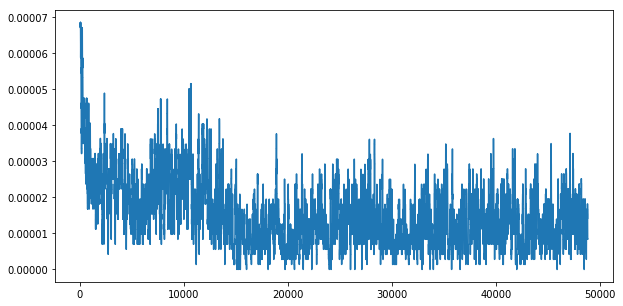

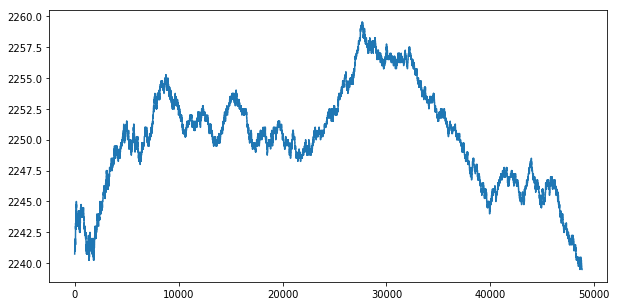

In [5]:
# first create some bars 
from mlfinlab.data_structures import get_dollar_bars
from mlfinlab.features.microstructural import high_low_estimator

date_time = data['Date and Time'] 
new_data = pd.concat([date_time, data['Price'], data['Volume']], axis=1)
new_data.columns = ['date', 'price', 'volume']
print(new_data.head(20))
print('\n')
print('Rows:', new_data.shape[0])
new_data.to_csv('./maks_tick_data.csv', index=False)

th = 10000
bars = get_dollar_bars('./maks_tick_data.csv', threshold=th, batch_size=1000000, verbose=True)
print('Bars:', bars.shape[0])

vol = high_low_estimator(bars.high, bars.low, window=50)
plt.figure(figsize=(10, 5))
vol.plot()
plt.figure(figsize=(10, 5))
bars.close.plot()

### Corwin-Shultz Algorithm

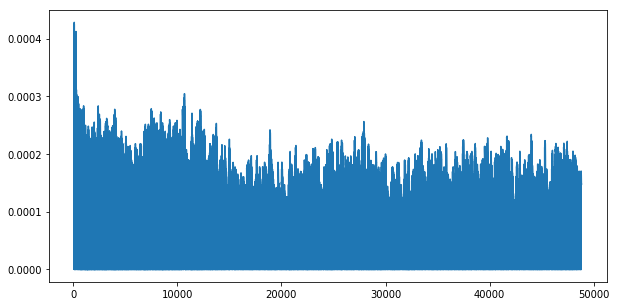

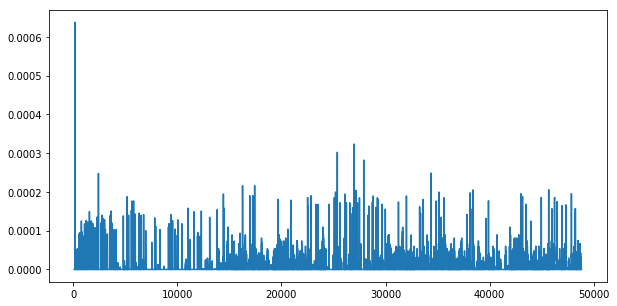

In [6]:
from mlfinlab.features.microstructural import corwin_shultz_spread, becker_parkinson_volatility
spread, start_ind = corwin_shultz_spread(bars.high, bars.low, 100)
vol = becker_parkinson_volatility(bars.high, bars.low, 100)

plt.figure(figsize=(10, 5))
spread.plot()
plt.figure(figsize=(10, 5))
vol.plot()

## Second generation: strategic trade models

### Kyle's Lambda

Reading data in batches:
Batch number: 0
Returning bars 



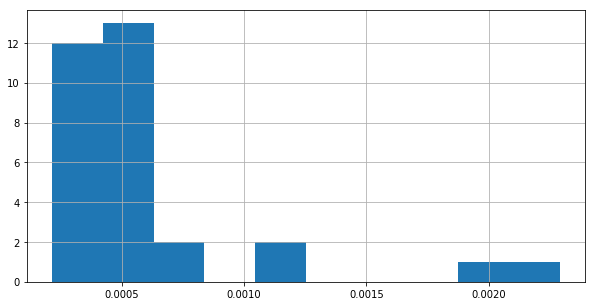

In [7]:
from mlfinlab.data_structures import BarFeature
from mlfinlab.features.microstructural import kyles_lambda, dollar_volume

kyles_lambda_feature = BarFeature(name='kyles_lambda', function= lambda df: kyles_lambda(df['price'], df['volume']))
bars = get_dollar_bars('./maks_tick_data.csv', threshold=70000000, batch_size=1000000,
                       additional_features=[kyles_lambda_feature])

plt.figure(figsize=(10, 5))
bars['kyles_lambda'].hist()

### Amihud's Lambda

In [8]:
from mlfinlab.features.microstructural import dollar_volume, amihuds_lambda
dollar_volume_feature = BarFeature(name='dollar_volume', function= lambda df: dollar_volume(df['price'], df['volume']))
bars = get_dollar_bars('./maks_tick_data.csv', threshold=70000000, batch_size=1000000,
                       additional_features=[dollar_volume_feature])
lambda_ = amihuds_lambda(bars['close'], bars['dollar_volume'])
lambda_

Reading data in batches:
Batch number: 0
Returning bars 



6.600161489263962e-10

### Hasbrouck's Lambda

In [9]:
from mlfinlab.features.microstructural import dollar_volume, hasbroucks_lambda, hasbroucks_flow

def get_hasbroucks_flow(df):
    tick_signs = tick_rule(df['price'])
    return hasbroucks_flow(df['price'], df['volume'], tick_signs)

hasbroucks_flow_feature = BarFeature(name='hasbroucks_flow', function=get_hasbroucks_flow)
bars = get_dollar_bars('./maks_tick_data.csv', threshold=70000000, batch_size=1000000,
                       additional_features=[hasbroucks_flow_feature])

lambda_ = hasbroucks_lambda(bars['close'], bars['hasbroucks_flow'])
lambda_

Reading data in batches:
Batch number: 0
Returning bars 



1.4467778933355137e-08

## Third generation: sequential trade models

### Volume-Synchronized Probability of Informed Trading

Reading data in batches:
Batch number: 0
Returning bars 



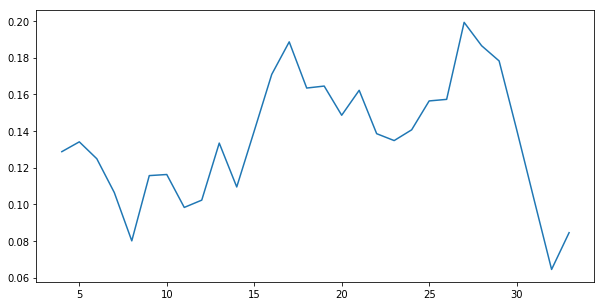

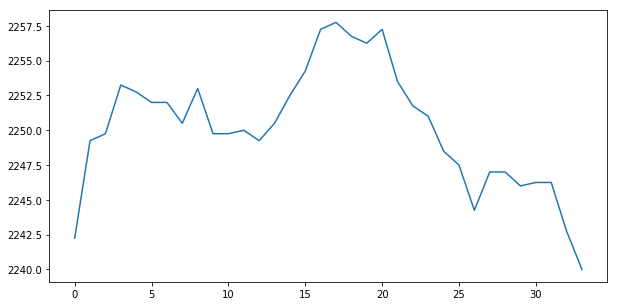

In [12]:
from mlfinlab.features.microstructural import vpin
from mlfinlab.data_structures import get_volume_bars

def buy_volume(df):
    tick_signs = tick_rule(df['price'])
    return (df['volume'] * (tick_signs > 0)).sum()

def sell_volume(df):
    tick_signs = tick_rule(df['price'])
    return (df['volume'] * (tick_signs < 0)).sum()
    
buy_volume_feature = BarFeature(name='buy_volume', function=buy_volume)
sell_volume_feature = BarFeature(name='sell_volume', function=sell_volume)

bars = get_volume_bars('./maks_tick_data.csv', additional_features=[buy_volume_feature, sell_volume_feature])
volume = 28224
vpin_series = vpin(bars['buy_volume'], bars['sell_volume'], volume, 5)
plt.figure(figsize=(10, 5))
vpin_series.plot()
plt.figure(figsize=(10, 5))
bars['close'].plot()

## Additional Features